<a href="https://colab.research.google.com/github/balazsmorv/AppleMusicKit/blob/main/KGT_ActiveLearning_ipynb_CLT8ZP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aktív tanulás

A múlt félév végén megvizsgáltuk a $K$-karú rabló-problémát, mint sok MI/megerősítéses tanulási/szekvenciális döntési feladat formális alapját. Ezt a keretet az orvosbiológiai kísérlettervezéstől kezdve a deep learning-alapú Go-játékos gépekig számos területen sikeresen alkalmazták; ezen a gyakorlaton egyszerűbb ágenseket fogunk implementálni az alapfeladat megoldására (néhányról volt szó az előadáson is).

## Emlékeztető

A félkarú rabló mintájára legyen adott $K$-karú játékgép, ahol, ha szerencsénk van, egy kart meghúzva valamekkora jutalomban (*reward*) részesülhetünk. Az egyes karok által adott jutalmak valószínűségi változók, amelyek ismeretlen, egymástól független eloszlásokat követnek. A célunk, hogy a karok egymás után történő húzogatásával
- Felfedezzük a problémateret, azaz megbecsüljük az egyes karok "jóságát" (*exploration*),
- Ezt a tudást kihasználva maximalizáljuk az összes jutalmunkat (*exploitation*).

Érezzük, hogy a két cél egymásnak ellentmond: a felfedezéshez szuboptimális karokat is meg kell húznunk, ezzel azonban az összes jutalmunkat csökkentjük. A karok valószínűségi természete miatt az is előfordulhat, hogy egy-egy "jó" kar éppen rossz jutalmat ad, így érdemes lehet a pillanatnyilag rossznak gondolt karokat is többször tesztelni. Ez az *exploration vs. exploitation* dilemma.

Bár az általunk vizsgált stratégiák többféle eloszlás esetében is működnek, mi a már jól ismert Bernoulli-eloszlást fogjuk használni. Azaz minden karhoz tartozik egy ismeretlen $\theta_k$ paraméter, egy húzás pedig egy Bernoulli-kísérletnek felel meg:

\begin{align}
p\left(x \mid \theta_k \right) = \mathcal{B}ern \left(x \mid \theta_k \right) = \theta_k^{x} (1-\theta_k)^{1-x},
\end{align}

ahol $x \in \left\lbrace 0,1 \right\rbrace$ a $k$. kar meghúzása után kapott jutalom. A továbbiakban jelölje $\bar x_k$ a $k.$ kar által adott jutalmak átlagát, $n_k$ azt, hogy hányszor húztuk meg a $k$. kart, $n$ pedig az összes húzások számát egészen mostanáig.

Egy stratégia fontos jellemzője a megbánás (*regret*), ami a mi esetünkben a következőképpen definiálható:

\begin{align}
\sum_{k=1}^K n_k \left(\theta^* - \theta_k \right), 
\end{align}

ahol $\theta^*$ a legjobb kar jutalmának várható értéke, $\theta_k$ pedig a $k$. karé (ami most, Bernoulli-eloszlásról lévén szó, megegyezik a paraméterrel). Azaz itt valójában azt mérjük, hogy várhatóan mennyit veszítünk amiatt, hogy a stratégiánk nem mindig a legjobb kart választja.

## Stratégiák

A következő stratégiákat fogjuk implementálni (az első kettőt láttuk előadáson):

- $\varepsilon$-greedy: adott $\varepsilon$ valószínűséggel felfedezünk, azaz véletlenszerűen válaszott kart húzunk meg; különben azt, amelyik eddig átlagosan a legnagyobb kifizetést adta (azaz $\bar x_k$ maximális).
- UCB1: először minden kart meghúzunk egyszer, majd mindig azt húzzuk, amelyik a $\bar x_k + \sqrt{\frac{2 \ln n}{n_k}}$ mennyiséget maximalizálja.
- UCB-$\alpha$: hasonlóan az előbbihez, de $\bar x_k + \sqrt{\frac{\alpha \ln n}{n_k}}$-t használunk.
- Thompson-mintavétel: minden karra felteszünk egy $\beta$ prior eloszlást, majd mintát veszünk és a maximálisat választjuk; a jutalom ismeretében a $\beta$-eloszlás frissítése a már ismert módon történik (konjugált eloszlások, tavalyi első labor).
- Bayesi UCB: hasonlóképpen fenntartunk egy $\beta$-eloszlást, de a választásnál nem mintát veszünk, hanem $1- \frac{1}{1+n}$ percentilist veszünk alapul (pl. a `beta.ppf()` függvénnyel).

## Feladatok

**1. feladat.** Valósítsa meg az ágenseket a lenti prototípus alapján! Az ágenseknek a `get_arm()` és az `update()` függvényeket kötelező implementálniuk.

A kiértékelést végezze el mind a 3 megadott paraméterezéssel. Ügyeljen rá, hogy az eredmények az egyes futásoknál eltérhetnek, így célszerű többször is lefuttatni a méréseket. Különösen az $\varepsilon$-greedy stratégia mutat nagy variabilitást; magyarázza meg, hogy miért!

**2. feladat.** Minden ágenshez ábrázolja scatter plot-on, mikor melyik kart húzta meg (vízszintes tengely: húzások, függőleges tengely: karok)! A plotok alapján hasonlítsa össze az ágensek felfedező tevékenységét!

**3. feladat.** Értékelje ki és hasonlítsa össze az ágensek teljesítményét! A következőket vegye alapul:

- Átlagos jutalom
- A legjobb kar meghúzásának relatív frekvenciája
- Regret

Az eredményeket az idő (húzások) függvényében is ábrázolja (azaz az ágens tároljon el minden ehhez szükséges információt)! Miben különbözik az $\varepsilon$-greedy ágens regret-je a többi módszerétől?

**4. feladat.** Tetszőleges problémában ábrázolja a bayesi UCB ágens $\beta$-posteriorjait a tanítás legvégén! Mit lehet megfigyelni? Miért mondhatjuk, hogy ez egy "optimista" stratégia?

In [1]:
%pylab inline
from scipy.stats import beta
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Prototípus ágens (példa)
class Agent:
  def __init__(self,K):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    self.arm = np.random.choice(self.K)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]

In [3]:
# 1. feladat megoldása (ágensek létrehozása)
# Prototípus ágens (példa)
class EGreedy:
  def __init__(self,K,e):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

    self.e = e # felfedezés valsége
    self.y = np.zeros(K) # az egyes karok eddigi jutalma
    self.n = np.ones(K) # az egyes karok meghúzása, laplace simítás

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    if np.random.rand() < self.e:
      self.arm = np.random.choice(self.K)
    else:
      self.arm = np.argmax(self.y / self.n)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.y[self.arm] += reward
    self.n[self.arm] += 1

In [4]:
class UCBA:
  def __init__(self,K, alpha):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma
    self.alpha = alpha # alpha = 2 esetén UCB1
    self.y = np.zeros(K) # az egyes karok eddigi jutalma
    self.n = np.ones(K) # az egyes karok meghúzása, laplace simítás

  def value_for_arm(self, arm_index):
    mean_xk = float(self.y[arm_index] / self.n[arm_index])
    return mean_xk + np.sqrt((self.alpha * np.log(sum(self.n))) / self.n[arm_index])

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    # ameddig nem húztuk meg minden kart addig mindig másikat húzunk
    not_yet_pulled_indices = np.flatnonzero(self.n < 2)
    if len(not_yet_pulled_indices) > 0:
      self.arm = np.random.choice(not_yet_pulled_indices)
    else:
      values = []
      for i in range(0, self.K):
        values.append(self.value_for_arm(i))
      self.arm = np.argmax(values)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.y[self.arm] += reward
    self.n[self.arm] += 1



In [5]:
class Thomson:
  def __init__(self, K, prior_a, prior_b):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

    self.prior_alphas = prior_a
    self.prior_betas = prior_b

    self.y = np.zeros(K) # az egyes karok eddigi jutalma
    self.n = np.ones(K) # az egyes karok meghúzása, laplace simítás

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    # mindegyik kar priorjából mintát veszünk, legnagyobbat választjuk
    samples = []
    for i in range(0, self.K):
      samples.append(np.random.beta(self.prior_alphas[i], self.prior_betas[i]))
    self.arm = np.argmax(samples)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.y[self.arm] += reward
    self.n[self.arm] += 1
    if reward == 1:
      self.prior_alphas[self.arm] += 1
    else:
      self.prior_betas[self.arm] += 1

In [6]:
class BayesianUCB:
  def __init__(self, K, prior_a, prior_b):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

    self.prior_alphas = prior_a
    self.prior_betas = prior_b

    self.y = np.zeros(K) # az egyes karok eddigi jutalma
    self.n = np.ones(K) # az egyes karok meghúzása, laplace simítás

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    # 1 - (1 / (1+n)) percentilist számolunk
    self.arm = np.argmax(beta.ppf(1 - (1/(1+sum(self.n))), self.prior_alphas, self.prior_betas))
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.y[self.arm] += reward
    self.n[self.arm] += 1
    if reward == 1:
      self.prior_alphas[self.arm] += 1
    else:
      self.prior_betas[self.arm] += 1

In [7]:
# Szimuláció T db húzással
def simulate(rewards,agent,T=10000):
  for t in range(T):
    arm    = agent.get_arm()
    reward = (np.random.rand()<rewards[arm])*1
    agent.update(reward)

In [8]:
#reward_probs = np.linspace(0.01,0.99,30)
reward_probs = [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]
#reward_probs = [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]

In [54]:
# 1. feladat megoldása (szimuláció) EGreedy

e_agent = EGreedy(len(reward_probs), 0.1)
simulate(reward_probs, e_agent)
print(e_agent.n)

[ 146.  118.  118.  100.  102.  347. 8749.  223.  106.]


Az epsilon-greedy stratégia nagy variabilitást mutat, mivel minden húzásnál 1-e valséggel (nagy) a legnagyobb átlagos kifizetésű kart húzzuk, ami messze lehet az optimálistól és nagy mértékben véletlenszerű, hiszen kis valséggel húzzuk meg a legjobb kart, illetve ha meghúzzuk, akkor se biztos hogy elégszer ahhoz, hogy az átlag kifizetése a legjobb legyen. Így az egyes futtatások végén eltérők lehetnek a legtöbbet húzott karok indexei.

In [12]:
# 1. feladat megoldása (szimuláció) UCB1 és UCBA

ucb1_agent = UCBA(len(reward_probs), 2.0)
simulate(reward_probs, ucb1_agent)
print(ucb1_agent.n)

ucbA_agent = UCBA(len(reward_probs), 5.0)
simulate(reward_probs, ucbA_agent)
print(ucbA_agent.n)

[  24.   24.   67.   58.  177.  254. 2593. 3181. 3631.]
[  56.   56.  121.  157.  323.  518. 2524. 3222. 3032.]


In [65]:
# 1. feladat megoldása (szimuláció) Thomson és Bayesi UCB

priorA = np.ones(len(reward_probs))
priorB = np.ones(len(reward_probs))

thomson_agent = Thomson(len(reward_probs), priorA, priorB)
simulate(reward_probs, thomson_agent)
print(thomson_agent.n)

bayesianUCB_agent = BayesianUCB(len(reward_probs), priorA, priorB)
simulate(reward_probs, bayesianUCB_agent)
print(bayesianUCB_agent.n)

[7.000e+00 6.000e+00 1.100e+01 2.700e+01 3.800e+01 5.200e+01 6.600e+01
 1.165e+03 8.637e+03]
[1.000e+00 1.000e+00 2.000e+00 3.000e+00 3.000e+00 2.000e+00 4.473e+03
 7.050e+02 4.819e+03]


****2. feladat****

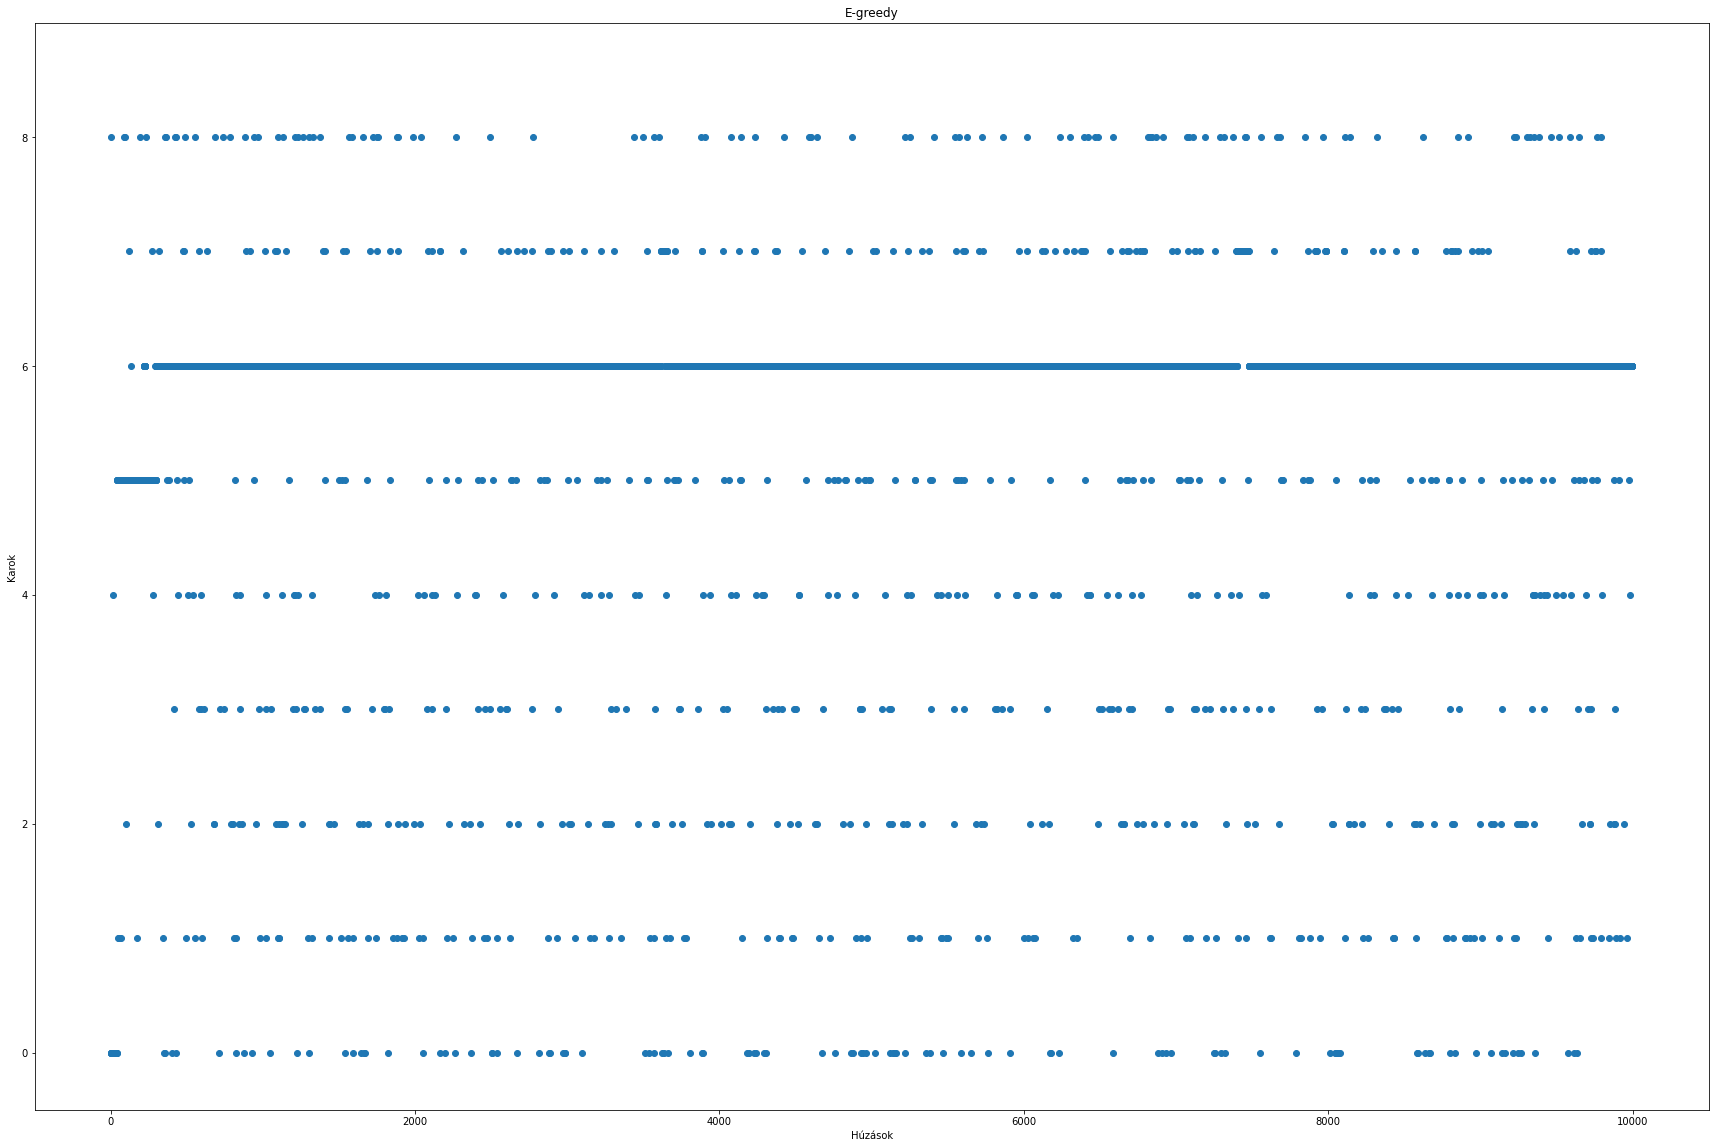

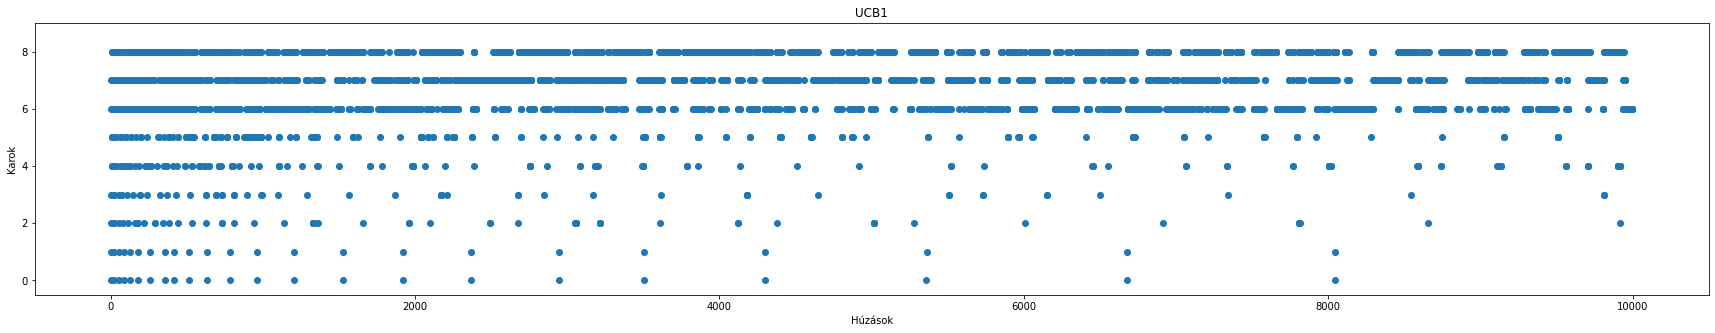

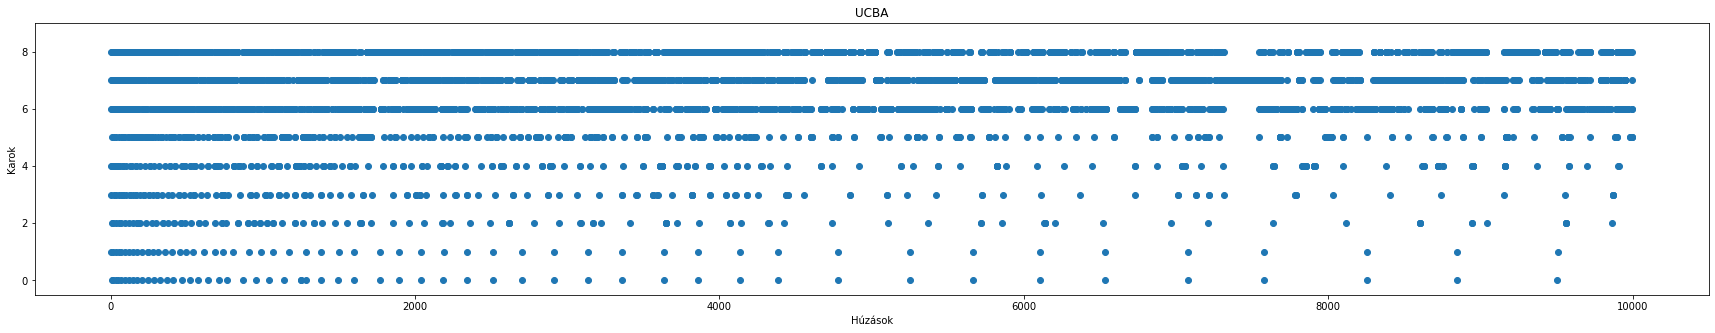

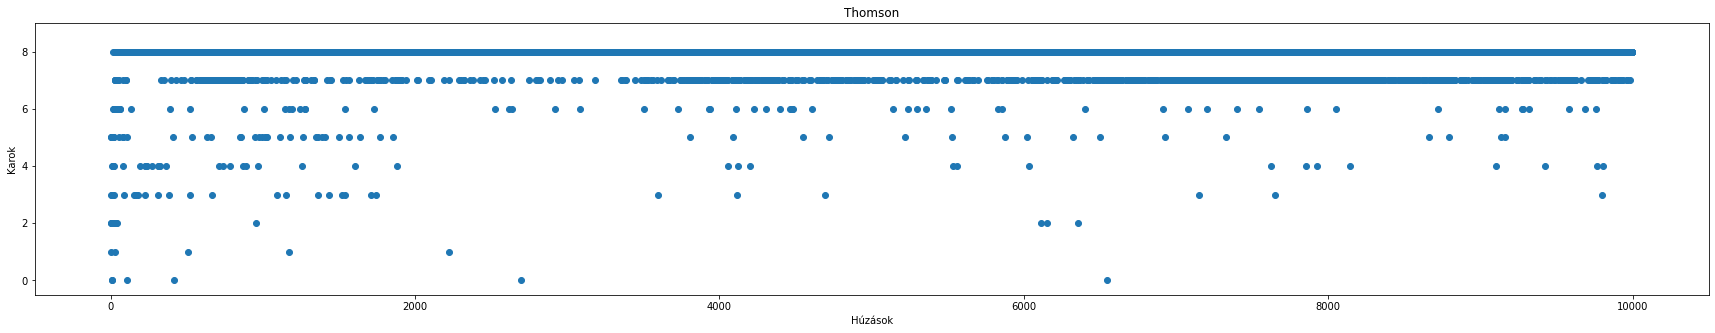

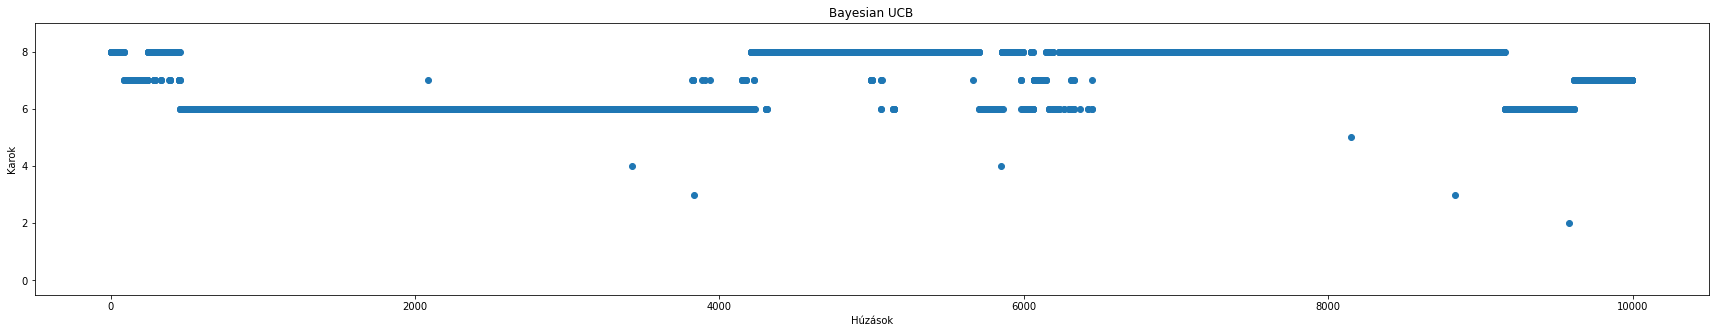

In [66]:
# 2. feladat megoldása
import matplotlib.pyplot as plt

def plotA(A, title):
  plt.title(title)
  plt.xlabel("Húzások")
  plt.ylabel("Karok")
  plt.rcParams["figure.figsize"] = (30,5)
  ax = plt.gca()
  ax.set_ylim([-0.5, 9])
  plt.plot(A, 'o')
  plt.show()

plotA(e_agent.A, "E-greedy")
plotA(ucb1_agent.A, "UCB1")
plotA(ucbA_agent.A, "UCBA")
plotA(thomson_agent.A, "Thomson")
plotA(bayesianUCB_agent.A, "Bayesian UCB")

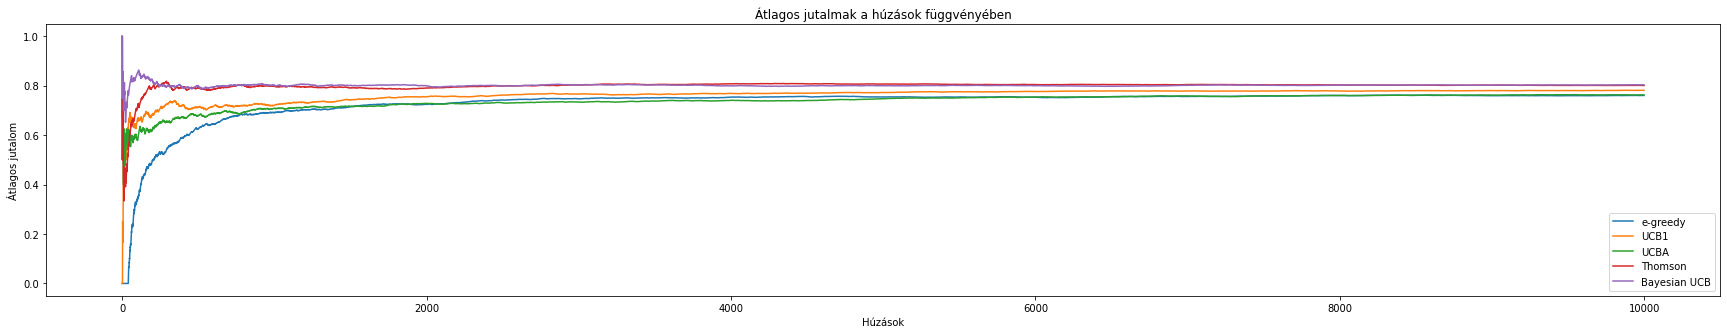

In [67]:
# 3. feladat megoldása - Átlagos jutalom

def moving_averages(X):
  averages = []
  for i in range(0, len(X)):
    averages.append(float(sum(X[0:i+1]) / float(i+1)))
  return averages

plt.title("Átlagos jutalmak a húzások függvényében")
plt.xlabel("Húzások")
plt.ylabel("Átlagos jutalom")
plt.rcParams["figure.figsize"] = (30,20)
plt.plot(moving_averages(e_agent.X), label= "e-greedy")
plt.plot(moving_averages(ucb1_agent.X), label= "UCB1")
plt.plot(moving_averages(ucbA_agent.X), label= "UCBA")
plt.plot(moving_averages(thomson_agent.X), label= "Thomson")
plt.plot(moving_averages(bayesianUCB_agent.X), label= "Bayesian UCB")
plt.legend()
plt.show()



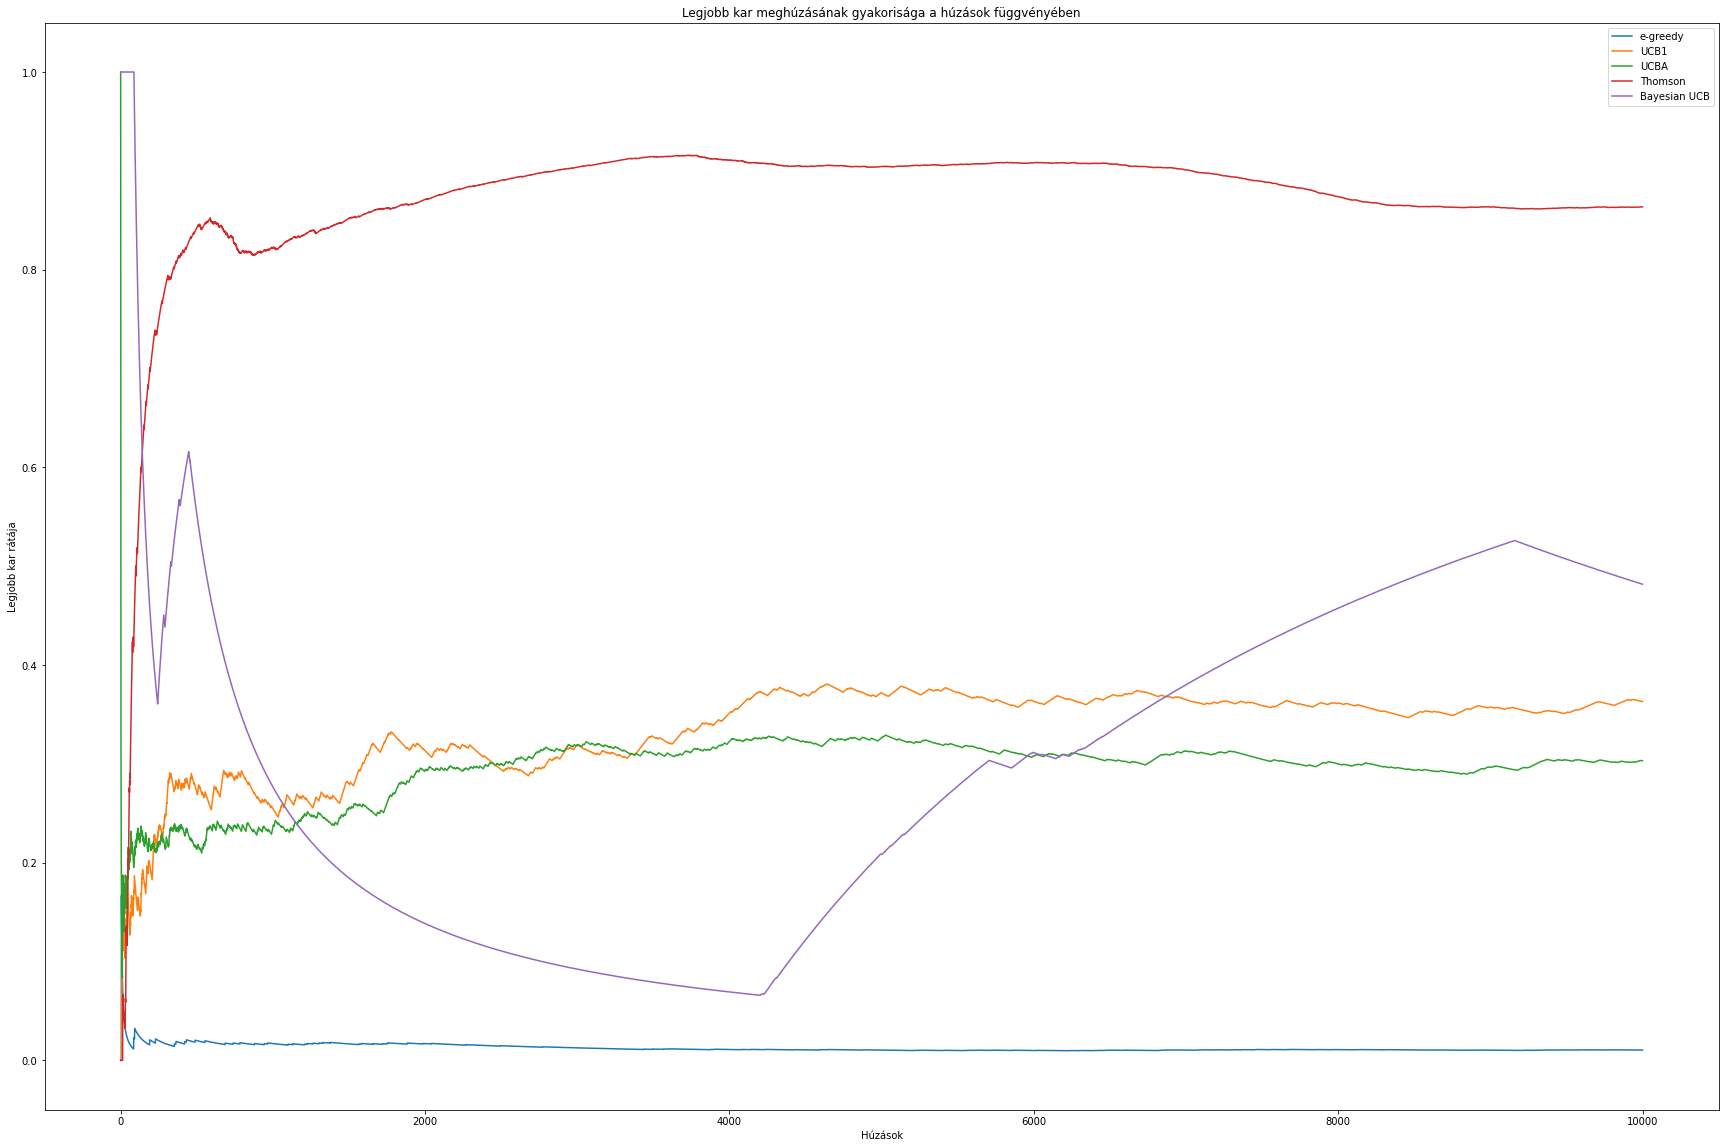

In [68]:
# 3. feladat megoldása - A legjobb kar meghúzásának relatív frekvenciája

def arm_frequency(A, arm):
  frequencies = []
  n = 0
  for i in range(0, len(A)):
    if A[i] == arm:
      n += 1
    frequencies.append(float(n / (i+1)))
  return frequencies

best_arm = np.argmax(reward_probs)

plt.title("Legjobb kar meghúzásának gyakorisága a húzások függvényében")
plt.xlabel("Húzások")
plt.ylabel("Legjobb kar rátája")
plt.rcParams["figure.figsize"] = (30,20)
plt.plot(arm_frequency(e_agent.A, best_arm), label= "e-greedy")
plt.plot(arm_frequency(ucb1_agent.A, best_arm), label= "UCB1")
plt.plot(arm_frequency(ucbA_agent.A, best_arm), label= "UCBA")
plt.plot(arm_frequency(thomson_agent.A, best_arm), label= "Thomson")
plt.plot(arm_frequency(bayesianUCB_agent.A, best_arm), label= "Bayesian UCB")
plt.legend()
plt.show()

In [ ]:
# 4. feladat megoldása
